# Exploring generations

In [158]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


In [2]:
def draw_generation(
    mols,
    width=800,
    height=600,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
    hit_ats=None,
):
    try:
        p = py3Dmol.view(width=width, height=height)
        if type(mols) is not list:
            mols = [mols]
        for mol in mols:
            if multipleConfs:
                for conf in mol.GetConformers():
                    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
                    p.addModel(mb, "sdf")
            else:
                if type(mol) is str:
                    if os.path.splitext(mol)[-1] == ".xyz":
                        xyz_f = open(mol)
                        line = xyz_f.read()
                        xyz_f.close()
                        p.addModel(line, "xyz")
                else:
                    mb = Chem.MolToMolBlock(mol, confId=confId)
                    p.addModel(mb, "sdf")
        p.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius":0.3}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}
        # 
        if hit_ats:
            hit_ats = [x for tup in hit_ats for x in tup]
            for atom in hit_ats:
                v = mol.GetConformer().GetAtomPosition(atom)
                v.addSphere(
                    {
                        "center": {"x": p.x, "y": p.y, "z": p.z},
                        "radius": 0.9,
                        "color": "green",
                        "alpha": 0.8,
                    }
                )
            v.setBackgroundColor("white")
            
        p.zoomTo()
        p.update()
        # p.show()
    except Exception as e:
        print(e)
        print("py3Dmol, RDKit, and IPython are required for this feature.")

# The original structure as reference:  

In [3]:
Mo_hipt_path = '/home/magstr/Documents/nitrogenase/schrock/reference_structures/mo.xyz'
draw_generation(Mo_hipt_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

{"stick": {"radius": 0.2}{"stick": {"radius": 0.2}### First test generation

In [135]:
templates = Path('../templates/')
generation_path = Path('~').expanduser()/"generation_data/100gen_test"

In [5]:
files = generation_path.rglob('*xtbopt.xyz')
paths = sorted(files)

In [6]:
Mo_NH3_paths = [path for path in paths if 'Mo' in str(path.parents[1])] 
catalyst_paths = [path for path in paths if 'catalyst' in str(path.parents[1])] 

In [7]:
len(catalyst_paths)

0

In [35]:
confs = catalyst_paths

def conf_viewer(idx):
    mol = confs[idx]
    gen = confs[idx].parts[-3].split('_')[0][1:]
    print(f'Generation : {gen}, {mol}')
    return draw_generation(str(confs[idx]))

#interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 216, 
# 38 shows something along the lines of HIPT. 
# 54 is a larger one
# 260 water
# 266 weird one

# 287 amines

In [63]:
confs = Mo_NH3_paths
#interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
#211 SH and NH4
# 188 Ligand break of

### The best ones from final generation

In [187]:
debug = Path('~/generation_data/generation_zi').expanduser()

In [189]:
with open(debug/'GA100.pkl', "rb") as f:
    gen10 = pickle.load(f)

In [190]:
for i,elem in enumerate(gen10.survivors.molecules[0:100]):
    newcore_path = f"xtbopt{i}.xyz"
    with open(debug/newcore_path, "w+") as f:
        for line in elem.structure:
            f.write(line)

In [191]:
mols = []
list_idx = []
cut_idx = []
score = []

for elem in gen10.survivors.molecules:
    mols.append(elem.rdkit_mol)
    
    list_idx.append(elem.idx)
    
    score.append(elem.score)
    
    cut_idx.append([elem.cut_idx])
    

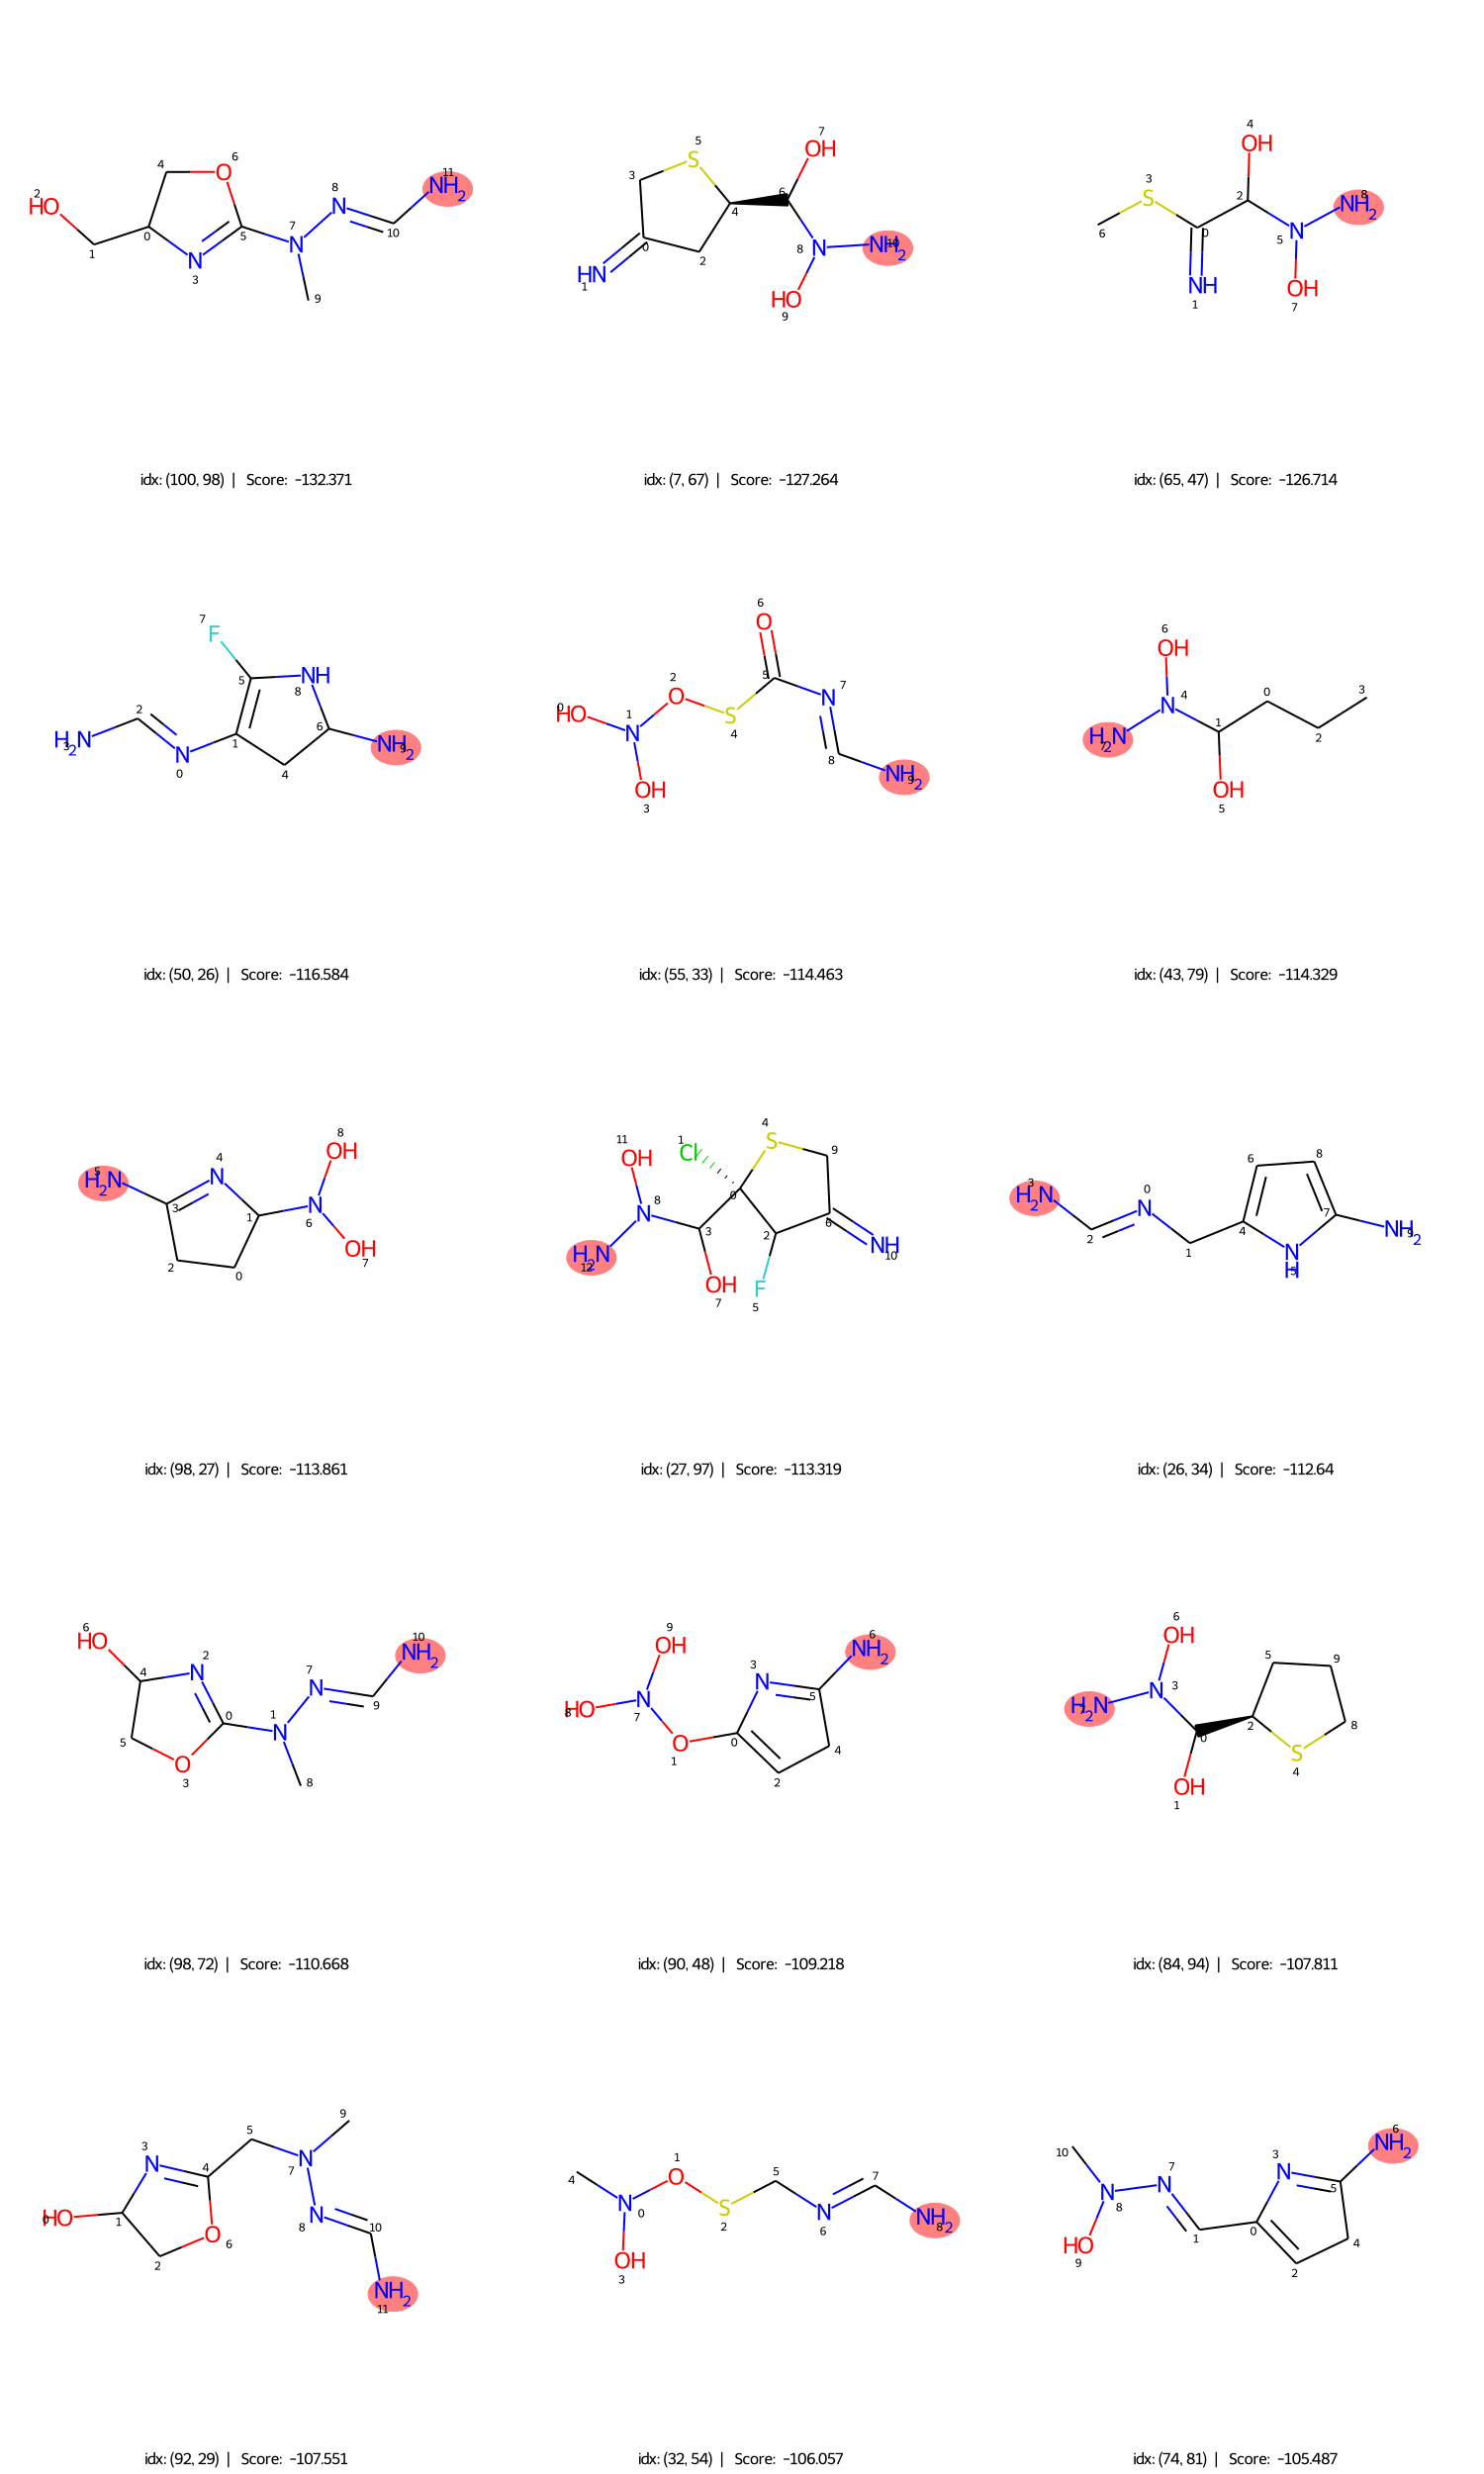

In [192]:
Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=15,legends=[f'idx: {x}  |   Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(500,500), highlightAtomLists=cut_idx,returnPNG=False)

In [193]:
files = debug.rglob('xtbopt*.xyz')
paths = sorted(files)

In [194]:
confs = paths

def conf_viewer(idx):
    mol = confs[idx]
    print(f'Generation : {mol}')
    return draw_generation(str(confs[idx]))

interact(conf_viewer, idx=IntSlider(min=0,max=len(confs)-1, step=1))
# 28, 15 a larger ones #100gen_test


# # vin_overnight100


#vin_overnight2 82 towards hipt!
# 6 - Lots of sulphur
# 85 larger 


#67 mixmix

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

### Energy evolution through time

In [83]:
def sort_ga(x):
    num = int(str(x).split('.pkl')[-2].split('GA')[-1])
    return num

# Get gen paths
gen_objects = sorted(path.rglob('GA*.pkl'), key=sort_ga)

In [84]:
avg_energy=[]
for elem in gen_objects:
    with open(elem, "rb") as f:
        f.seek(0)
        gen = pickle.load(f)
        
        df = gen.gen2pd()['score']
        df = df[df < 1000]
        
        avg_energy.append(df.mean())

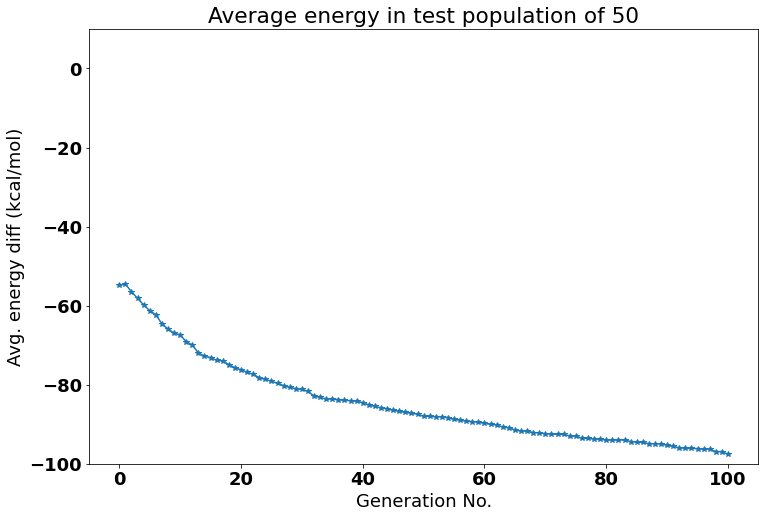

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(0,len(avg_energy))
ax.plot(x,avg_energy,'*-')
ax.set(xlabel='Generation No.', ylabel='Avg. energy diff (kcal/mol)', title='Average energy in test population of 50', ylim =(-100,10));
fig.savefig('generation__100gen_avgenergy.png', dpi=600)

### Explore replace core functionality

In [20]:
from rdkit.Chem import MolToSmiles, MolFromSmiles, ReplaceCore
mol = MolFromSmiles('CCN(CC)CC')
core = Chem.MolFromSmarts("[NX3;H0]")

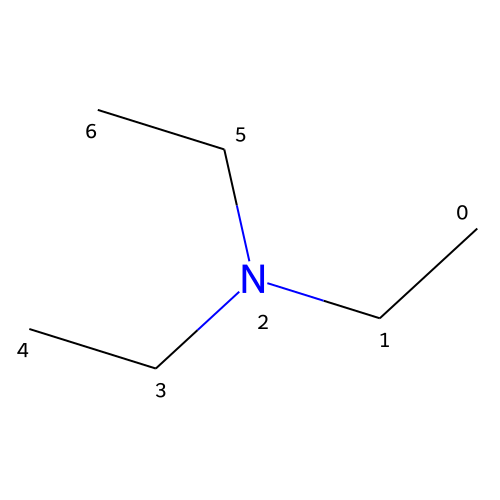

In [21]:
mol

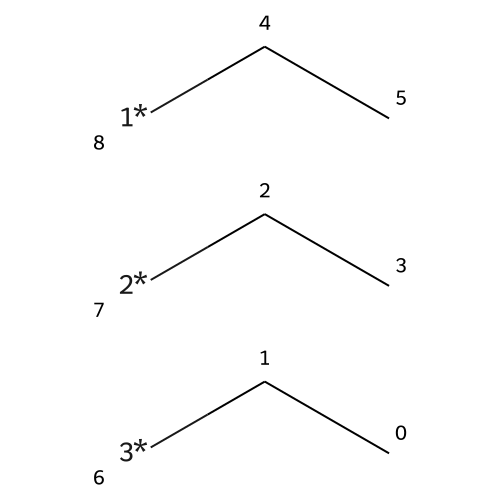

In [22]:
ReplaceCore(mol, core, mol.GetSubstructMatch(core))

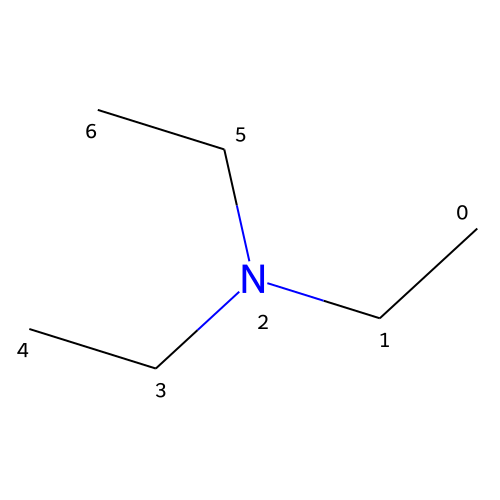

In [13]:
mol